# Biol 359A  | Principal Component Analysis
### Spring 2022, Week 9
<hr>
Learning Objectives:

  - Understand motivations of dimension reduction
  - Discuss applications towards data visualization and data exxploration
  - Interpret the results of a principal component analysis


In [ ]:
#!git clone https://github.com/BIOL359A-FoundationsOfQBio-Spr22/week9_principalcomponentanalysis
#!mkdir ./data
#!cp week9_principalcomponentanalysis/data/* ./data
#!pip install palmerpenguins

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import sklearn as sk
import matplotlib.pyplot as plt

from palmerpenguins import load_penguins

from sklearn.decomposition import PCA
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

%matplotlib inline

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

TITLE_FONT = 20
LABEL_FONT = 16
TICK_FONT = 16
FIG_SIZE = (8,8)
COLORS= ["#008080","#CA562C"]

sns.set(font_scale=1.5, rc={'figure.figsize':FIG_SIZE}) 
sns.set_style()
plt.rc("axes.spines", top=False, right=False)


## First we're going to generate a toy dataset

Notice the direction where the most variance occurs. This line will be slightly different from our linear regression line, because in PCA we're treating these variables the same. (We care about the error in both the x and y direction, rather than simply the y-direction).

We then generate the eigen vector of our covariance matrix, and plot it over the original data. 

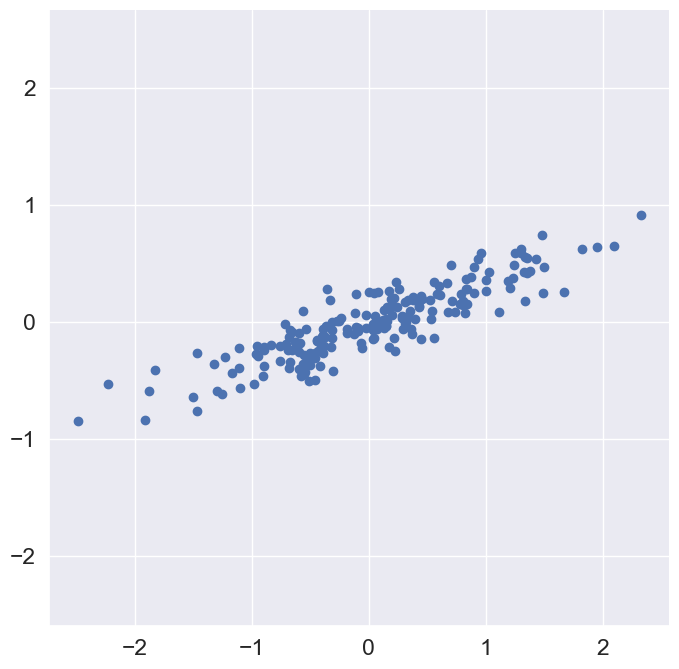

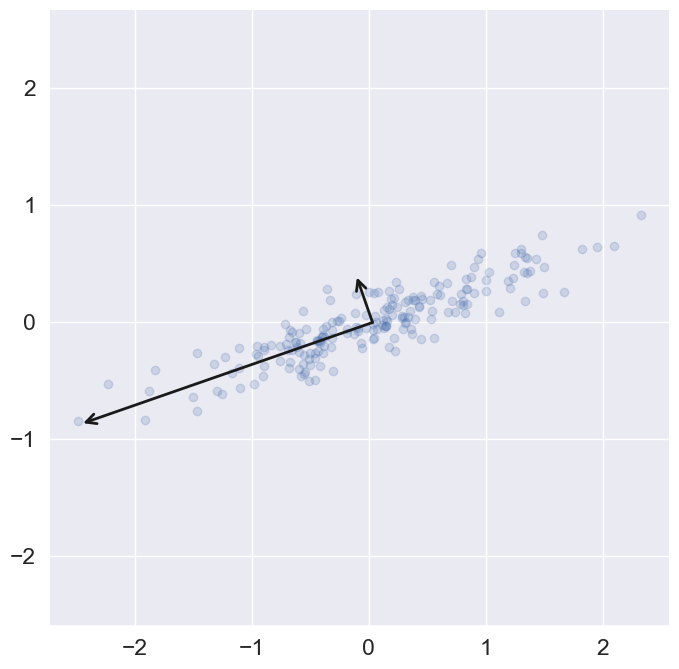

In [2]:
def example_pca():
    rng = np.random.RandomState(1)
    X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
    plt.scatter(X[:, 0], X[:, 1])
    plt.axis('equal')
    plt.show()
    pca = PCA(n_components=2)
    pca.fit(X)

    # plot data
    plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
    for length, vector in zip(pca.explained_variance_, pca.components_):
        v = vector * 3 * np.sqrt(length)
        draw_vector(pca.mean_, pca.mean_ + v)
    plt.axis('equal');
    plt.show()

def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    color='k',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

example_pca()

### Coordinate System
Now that we have the eigenvectors, we can do two things with them.
First, we're going to look at using them as a new coordinate system.

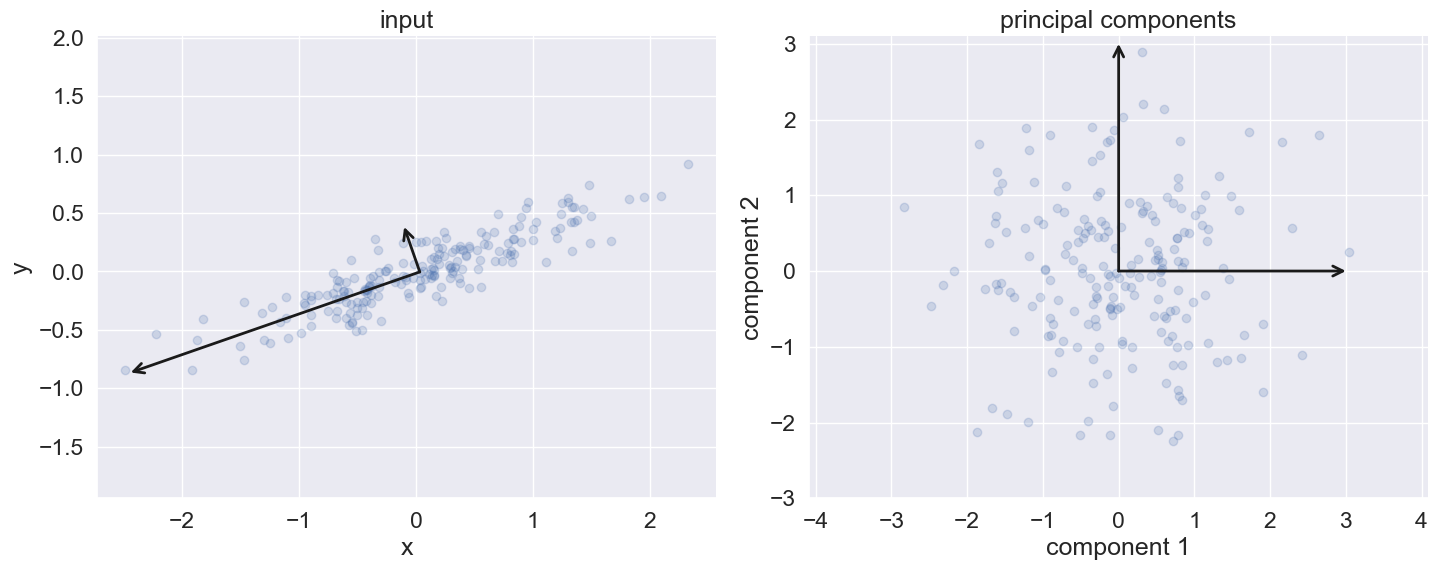

In [3]:
def coordinatesystem_example():
    rng = np.random.RandomState(1)
    X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
    pca = PCA(n_components=2, whiten=True)
    pca.fit(X)

    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.15)

    # plot data
    ax[0].scatter(X[:, 0], X[:, 1], alpha=0.2)
    for length, vector in zip(pca.explained_variance_, pca.components_):
        v = vector * 3 * np.sqrt(length)
        draw_vector(pca.mean_, pca.mean_ + v, ax=ax[0])
    ax[0].axis('equal');
    ax[0].set(xlabel='x', ylabel='y', title='input')

    # plot principal components
    X_pca = pca.transform(X)
    ax[1].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.2)
    draw_vector([0, 0], [0, 3], ax=ax[1])
    draw_vector([0, 0], [3, 0], ax=ax[1])
    ax[1].axis('equal')
    ax[1].set(xlabel='component 1', ylabel='component 2',
              title='principal components',
              xlim=(-5, 5), ylim=(-3, 3.1))
coordinatesystem_example()

### Projection
The other option we have is to simply use one principal component, and represent our data with one vector rather than two. What does this accomplish? 

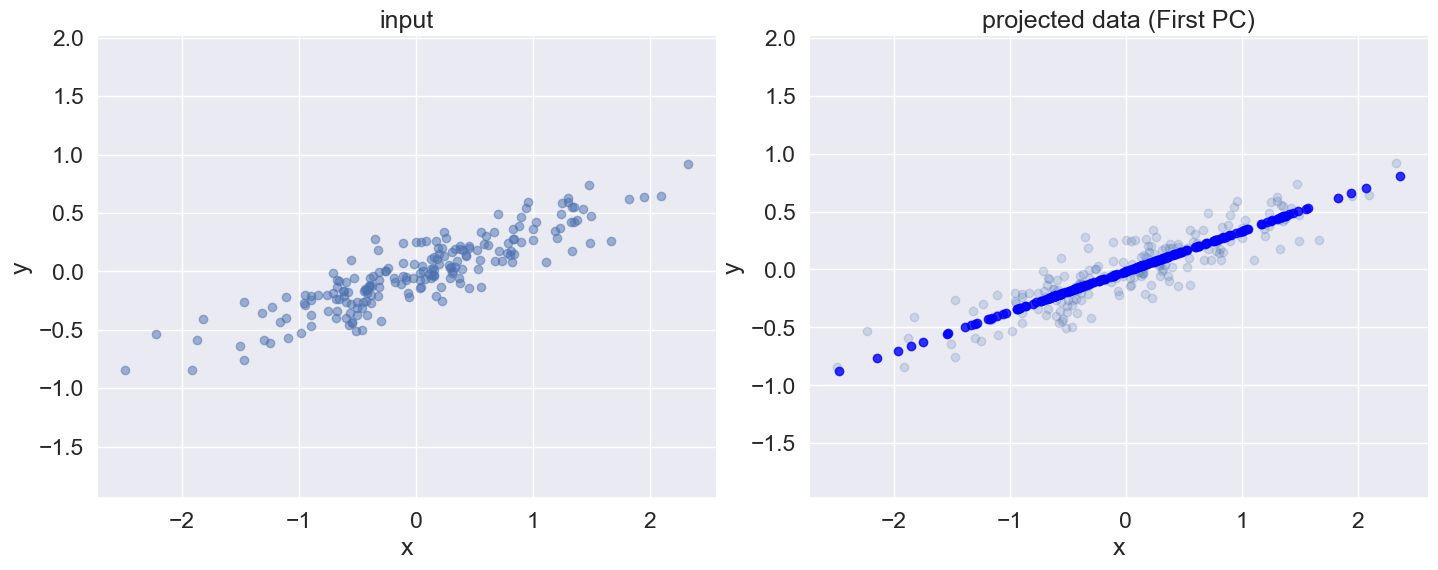

In [4]:
def projection_example():
    rng = np.random.RandomState(1)
    X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
    pca = PCA(n_components=2, whiten=True)
    pca.fit(X)

    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.15)

    # plot data
    ax[0].scatter(X[:, 0], X[:, 1], alpha=0.5)
    ax[0].axis('equal');
    ax[0].set(xlabel='x', ylabel='y', title='input')

    # plot principal components
    pca = PCA(n_components=1, whiten=True)
    pca.fit(X)
    X_pca = pca.transform(X)
    X_new = pca.inverse_transform(X_pca)
    ax[1].scatter(X[:, 0], X[:, 1], alpha=0.2)
    ax[1].scatter(X_new[:, 0], X_new[:, 1], color="blue", alpha=0.8)
    ax[1].axis('equal')
    ax[1].set(xlabel='x', ylabel='y',
              title='projected data (First PC)')
    
projection_example()

In [5]:
def PerformPCA(X, n_dimensions=10, plot=True):
    """
    Uses sklearn PCA tool to perform PCA
    input:
    X: Pandas Dataframe or Numpy Array of features
    n_dimensions: Number of PCs to fit

    output:
    X_pca: Pandas dataframe with column titles of PC1,...,PCn
    """
    X_standardized = StandardScaler().fit_transform(X)
    pca = PCA(n_components=n_dimensions)
    pca.fit(X_standardized)
    X_pca_array = pca.transform(X_standardized)
    column_names = ['PC{}'.format(i+1) for i in range(n_dimensions)] 
    X_pca = pd.DataFrame(X_pca_array, columns=column_names)
    if plot:
        plt.plot(column_names, np.cumsum(pca.explained_variance_ratio_), 'o--')
        plt.title('Skree Plot', fontsize=TITLE_FONT)
        plt.xlabel('Number of PCs', fontsize=LABEL_FONT)
        plt.ylabel('Total Percent Variance Explained', fontsize=LABEL_FONT)
        plt.ylim(0,1)
        plt.show()
    return X_pca

### Now we are going to explore a couple datasets that we've looked at before with PCA
We **could** plot all of our data against each other, and that usually makes sense for small datasets.

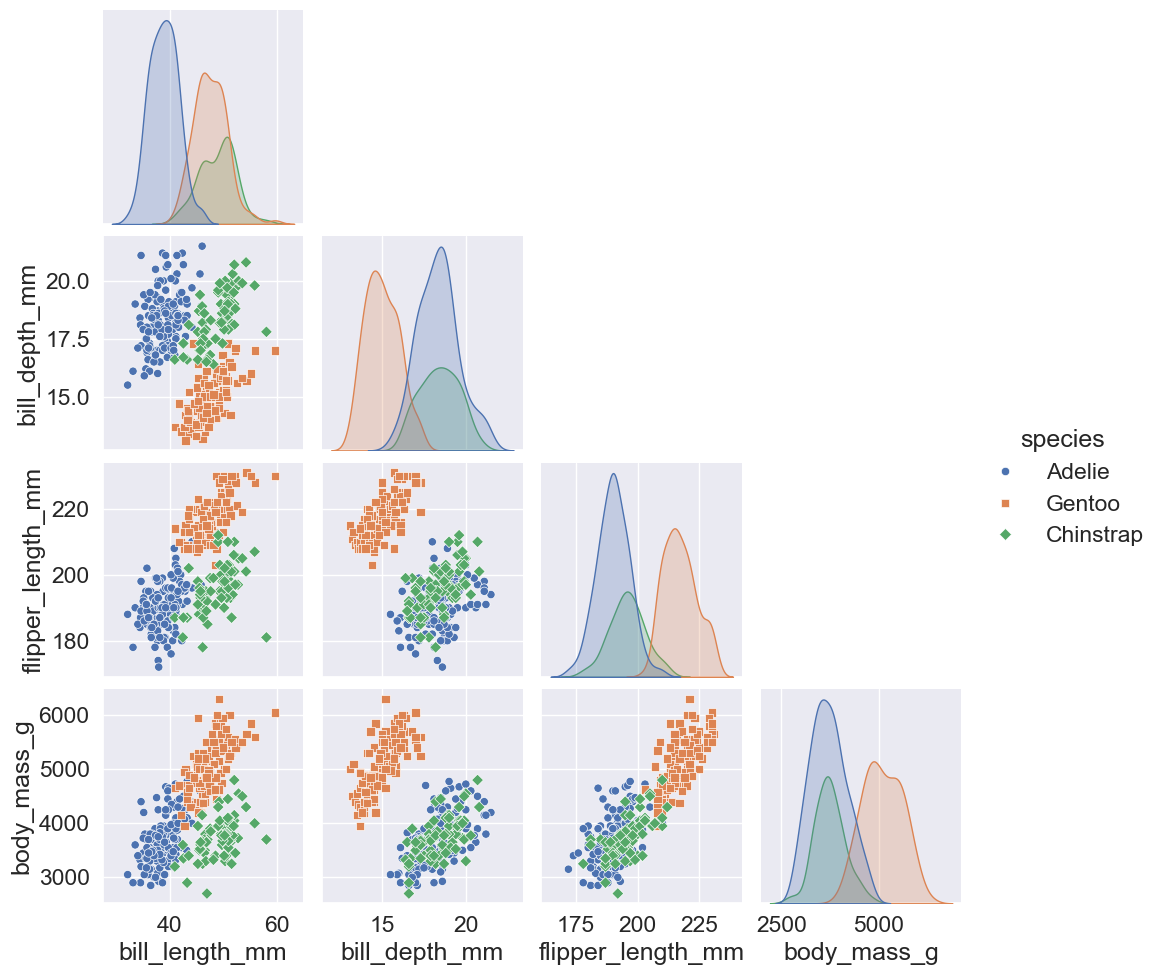

In [6]:
penguins=load_penguins()
penguins.dropna(inplace=True)
features=["bill_length_mm", "bill_depth_mm", "flipper_length_mm","body_mass_g"]
label='species'
sns.pairplot(penguins, vars=features, corner=True, hue="species", markers=["o", "s", "D"])

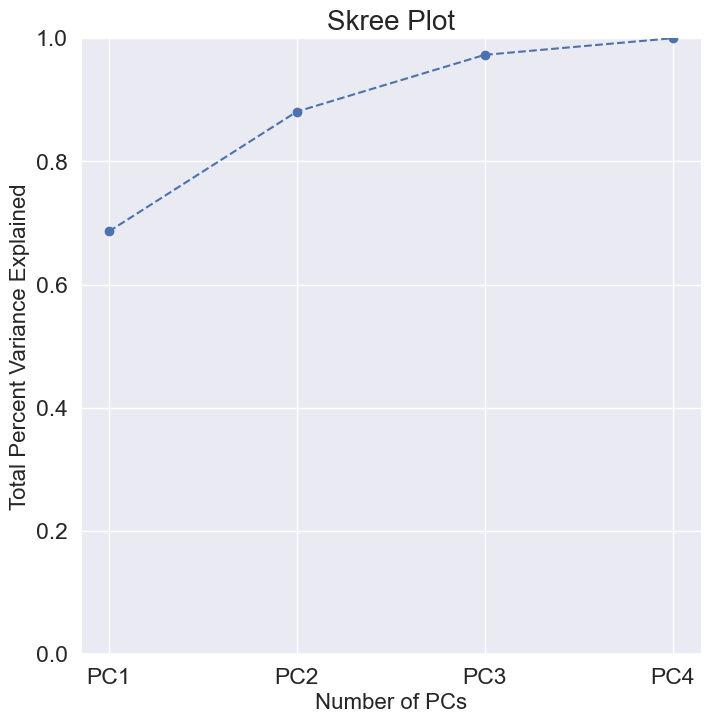

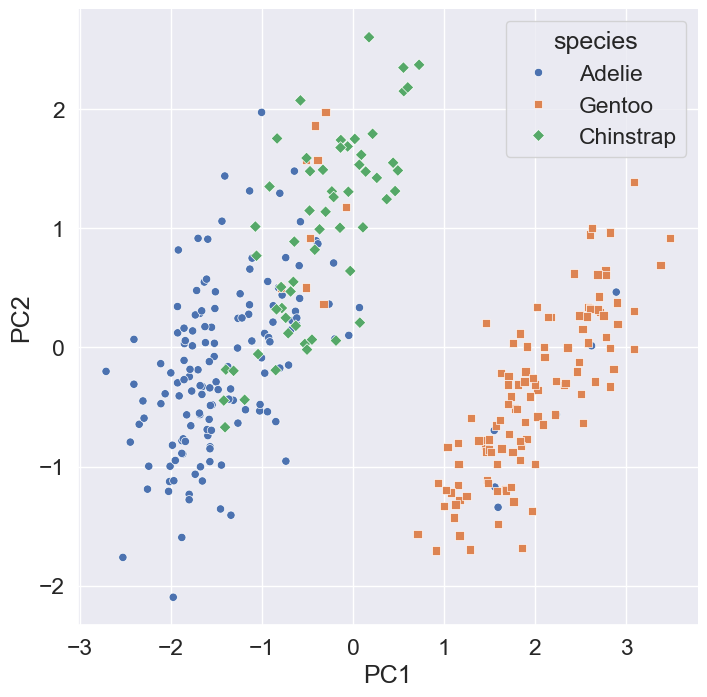

In [7]:
penguins_X = penguins[features]
penguins_y = penguins[label]
penguins_PCA_df = PerformPCA(penguins_X, n_dimensions=4)
penguins_PCA_df = penguins_PCA_df.join(penguins_y)
sns.scatterplot(x='PC1',y='PC2',hue='species',data=penguins_PCA_df,style='species',markers=["o", "s", "D"])
plt.show()

<Axes: xlabel='species', ylabel='PC1'>

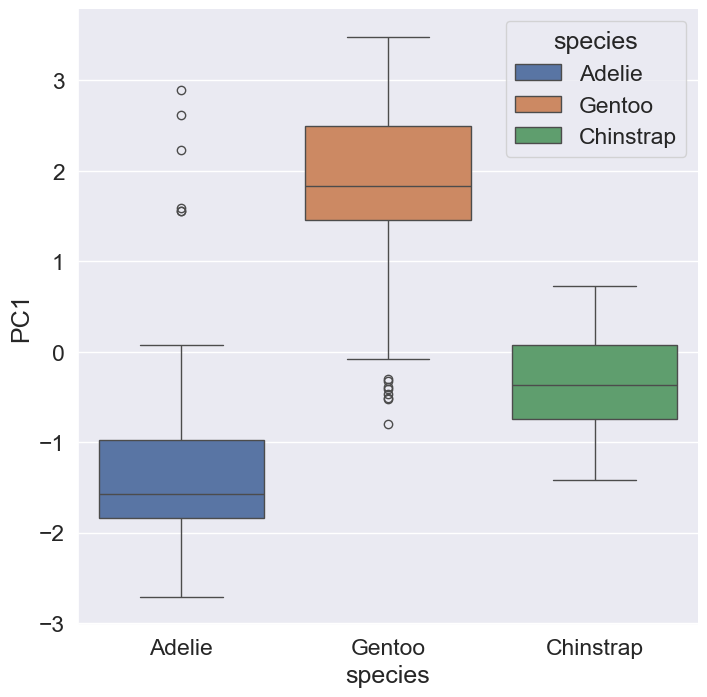

In [8]:
sns.boxplot(x="species", y="PC1", hue="species",
                 data=penguins_PCA_df)

<Axes: xlabel='species', ylabel='PC2'>

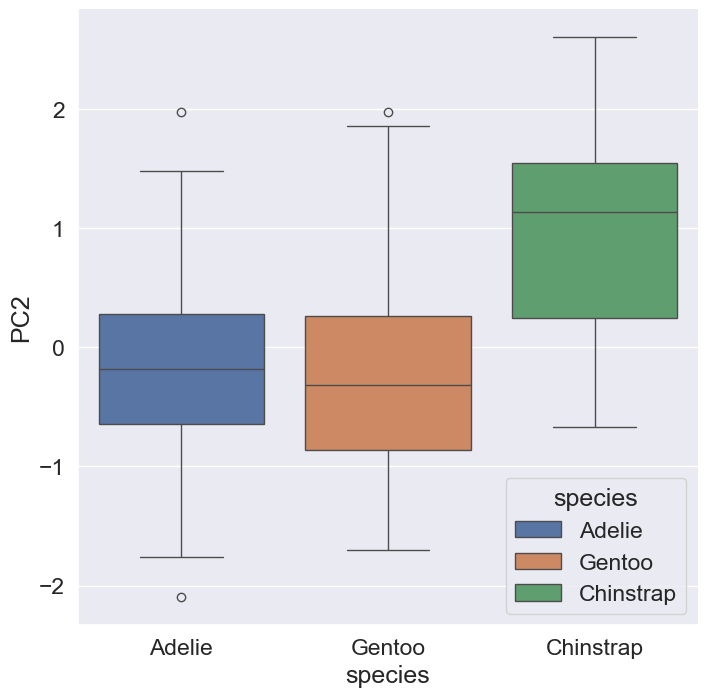

In [9]:
sns.boxplot(x="species", y="PC2", hue="species",
                 data=penguins_PCA_df)

## We are going to look at our trusty breast cancer dataset

Remember, we could build fairly effective classification models with this dataset.

In [10]:
cancer_raw = load_breast_cancer()
print(cancer_raw.DESCR)
tumor_features = pd.DataFrame(cancer_raw.data, columns=cancer_raw.feature_names)
tumor = pd.DataFrame(cancer_raw.target, columns=['tumor'])
tumor_nominal = tumor.replace({'tumor': {0: 'benign', 1: 'malignant'}})
cancer_df = pd.concat([tumor_features, tumor_nominal], axis=1)
tumor_features.describe()

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, field
    10 is Radius SE, field 20 is Worst Radius.

    - 

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


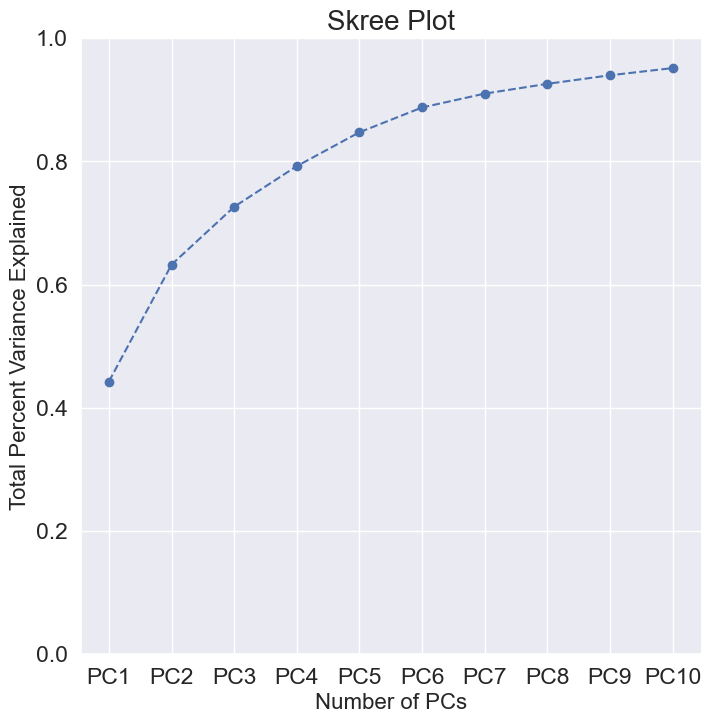

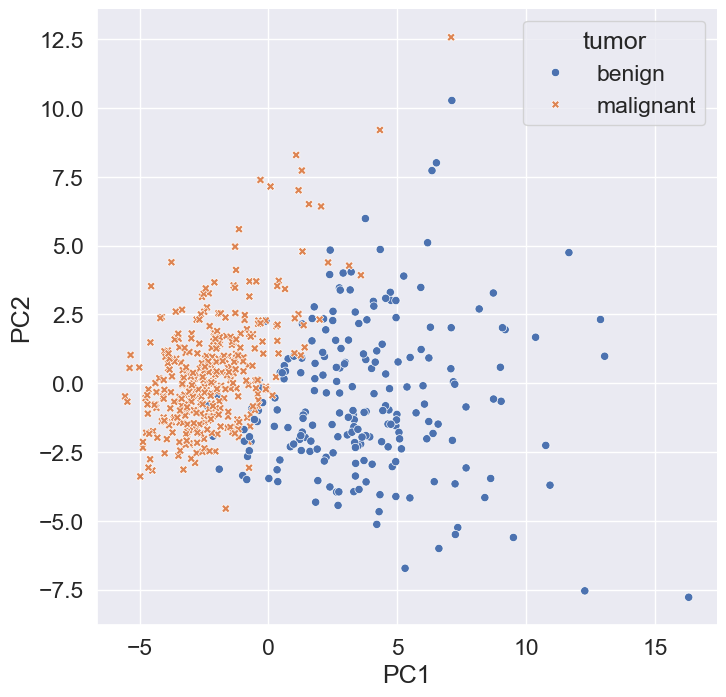

In [11]:
PCA_df = PerformPCA(tumor_features)
PCA_df = PCA_df.join(tumor_nominal)
sns.scatterplot(x='PC1',y='PC2',style='tumor',hue='tumor',data=PCA_df,markers=True)
plt.show()

But if I plot different PCs...

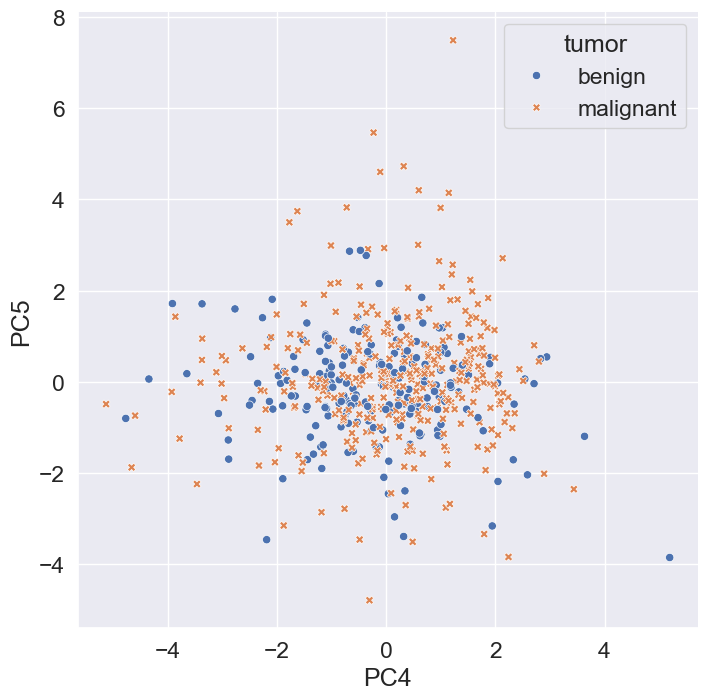

In [12]:
sns.scatterplot(x='PC4',y='PC5',style='tumor',hue='tumor',data=PCA_df,markers=True)
plt.show()